In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import seaborn as sns
import logging

import logging
import sys

def setup_logging(epoch_key, date_format='%d-%b-%y %H:%M:%S', format='%(asctime)s %(message)s'):
    animal, day, epoch = epoch_key
    log_filename = f"{animal}_{day:02d}_{epoch:02d}.log"

    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    formatter = logging.Formatter(fmt=format, datefmt=date_format)

    stdout_handler = logging.StreamHandler(sys.stdout)
    stdout_handler.setLevel(logging.INFO)
    stdout_handler.setFormatter(formatter)

    file_handler = logging.FileHandler(log_filename)
    file_handler.setLevel(logging.INFO)
    file_handler.setFormatter(formatter)

    logger.addHandler(file_handler)
    logger.addHandler(stdout_handler)

sns.set_context("talk")

In [3]:
epoch_key = 'Jaq', 3, 12

In [4]:
setup_logging(epoch_key)

In [5]:
from src.load_data import load_data
from src.parameters import EDGE_ORDER, EDGE_SPACING


data = load_data(epoch_key,
                 position_to_linearize=['nose_x', 'nose_y'],
                 max_distance_from_well=5,
                 min_distance_traveled=30)

22-Dec-20 11:18:53 Loading position info...
22-Dec-20 11:19:24 Loading multiunit...
22-Dec-20 11:19:45 Loading spikes...
22-Dec-20 11:21:05 Finding ripple times...


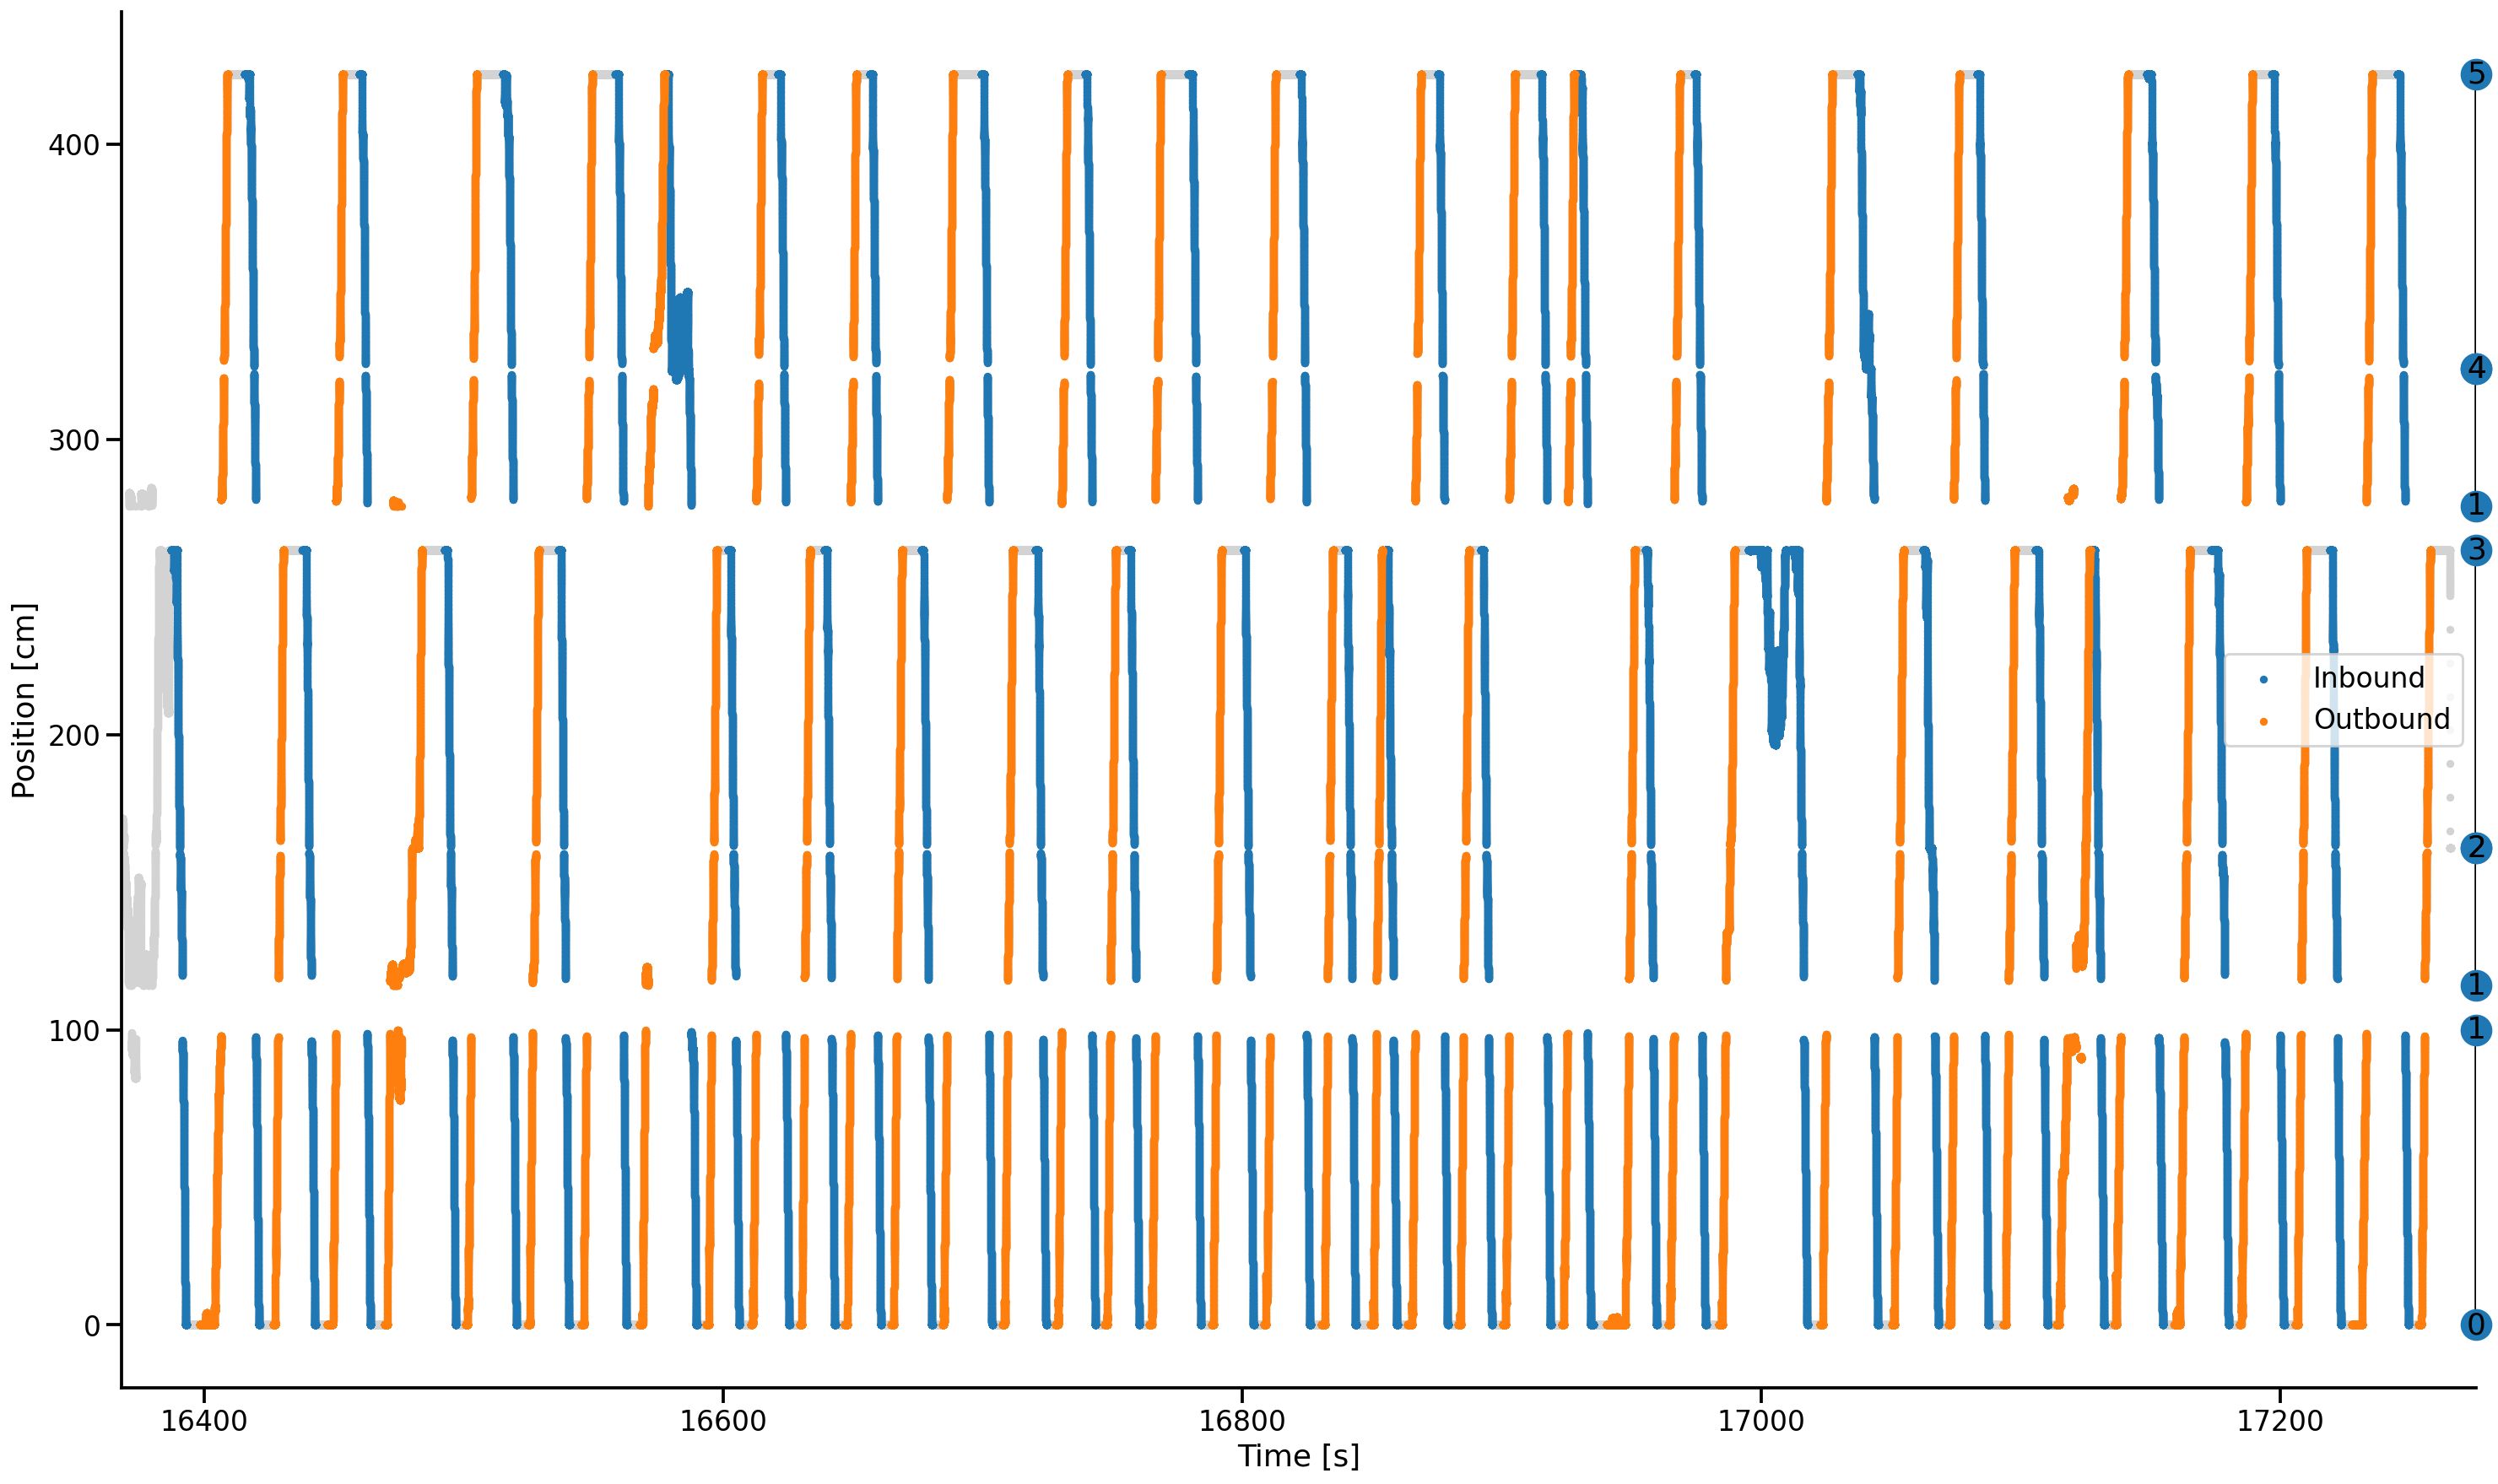

In [6]:
from track_linearization import plot_graph_as_1D
from src.parameters import EDGE_ORDER, EDGE_SPACING

plt.figure(figsize=(25, 15))

time = data['position_info'].index / np.timedelta64(1, 's')
plt.scatter(time,
            data['position_info'].linear_position, color='lightgrey', s=10)

for name, df in data['position_info'].groupby('task'):
    plt.scatter(df.index / np.timedelta64(1, 's'), df.linear_position, s=10, label=name)

plot_graph_as_1D(data['track_graph'], edge_order=EDGE_ORDER, edge_spacing=EDGE_SPACING, axis='y', 
                 other_axis_start=10.0 + time[-1])

plt.legend()
plt.ylabel('Position [cm]')
plt.xlabel('Time [s]')
plt.xlim((time[0], time[-1] + 10.0))

sns.despine()

In [7]:
continuous_transition_types = (
    [['random_walk', 'uniform'],
     ['uniform',     'uniform']])


classifier_parameters = {
    'movement_var': 6.0,
    'replay_speed': 1,
    'place_bin_size': 2.5,
    'continuous_transition_types': continuous_transition_types,
    'discrete_transition_diag': 0.968,
    'model_kwargs': {
        'bandwidth': np.array([20.0, 20.0, 20.0, 20.0, 8.0])}, 
}

In [8]:
import pandas as pd

notnull = pd.notnull(data["position_info"].task)

In [ ]:
from replay_trajectory_classification import ClusterlessClassifier

from sklearn.model_selection import KFold
from tqdm.auto import tqdm

state_names = ['Continuous', 'Fragmented']
cv = KFold()
cv_classifier_clusterless_results = []

for fold_ind, (train, test) in enumerate(cv.split(data["position_info"].index)):
    logging.info(f'Fitting Fold #{fold_ind + 1}...')
    cv_classifier = ClusterlessClassifier(**classifier_parameters)
    cv_classifier.fit(
        position=data["position_info"].iloc[train].linear_position,
        multiunits=data["multiunits"].isel(time=train),
        is_training=notnull.iloc[train],
        track_graph=data["track_graph"],
        edge_order=EDGE_ORDER,
        edge_spacing=EDGE_SPACING,
    )

    logging.info('Predicting posterior...')
    cv_classifier_clusterless_results.append(
        cv_classifier.predict(
            data["multiunits"].isel(time=test),
            time=data["position_info"].iloc[test].index / np.timedelta64(1, "s"),
            state_names=state_names
        )
    )
    
# concatenate cv classifier results 
cv_classifier_clusterless_results = xr.concat(
    cv_classifier_clusterless_results, dim="time"
)
logging.info('Done...\n\n')

22-Dec-20 11:22:17 Fitting Fold #1...
22-Dec-20 11:22:17 Fitting initial conditions...
22-Dec-20 11:22:18 Fitting state transition...
22-Dec-20 11:22:18 Fitting multiunits...
22-Dec-20 11:22:21 Predicting posterior...


In [ ]:
cv_classifier_clusterless_results

In [ ]:
# save the results as .nc format. ncread matlab can read these
cv_classifier_clusterless_results.to_netcdf(
   f"{epoch_key[0]}_{epoch_key[1]:02d}_{epoch_key[2]:02d}_cv_classifier_clusterless_nose_no_vel_results.nc"
)

In [ ]:
from src.visualization import plot_classifier_inbound_outbound_time_slice

time_slice = cv_classifier_clusterless_results.time[slice(70_000, 80_000)]

plot_classifier_inbound_outbound_time_slice(
    time_slice,
    cv_classifier,
    cv_classifier_clusterless_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(30, 15),
)

In [ ]:
from src.visualization import plot_classifier_inbound_outbound_time_slice

time_slice = cv_classifier_clusterless_results.time[slice(80_000, 90_000)]

plot_classifier_inbound_outbound_time_slice(
    time_slice,
    cv_classifier,
    cv_classifier_clusterless_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(30, 15),
)

In [ ]:
from src.visualization import plot_classifier_inbound_outbound_time_slice

time_slice = cv_classifier_clusterless_results.time[slice(100_000, 110_000)]

plot_classifier_inbound_outbound_time_slice(
    time_slice,
    cv_classifier,
    cv_classifier_clusterless_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(30, 15),
)

In [ ]:
from src.visualization import plot_classifier_inbound_outbound_time_slice

time_slice = cv_classifier_clusterless_results.time[slice(110_000, 120_000)]

plot_classifier_inbound_outbound_time_slice(
    time_slice,
    cv_classifier,
    cv_classifier_clusterless_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(30, 15),
)

In [ ]:
from src.visualization import plot_classifier_inbound_outbound_time_slice

time_slice = cv_classifier_clusterless_results.time[slice(120_000, 130_000)]

plot_classifier_inbound_outbound_time_slice(
    time_slice,
    cv_classifier,
    cv_classifier_clusterless_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(30, 15),
)

In [ ]:
from src.visualization import plot_classifier_inbound_outbound_time_slice

time_slice = cv_classifier_clusterless_results.time[slice(130_000, 140_000)]

plot_classifier_inbound_outbound_time_slice(
    time_slice,
    cv_classifier,
    cv_classifier_clusterless_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(30, 15),
)

In [ ]:
from src.visualization import plot_classifier_inbound_outbound_time_slice

time_slice = cv_classifier_clusterless_results.time[slice(140_000, 150_000)]

plot_classifier_inbound_outbound_time_slice(
    time_slice,
    cv_classifier,
    cv_classifier_clusterless_results,
    data,
    posterior_type="acausal_posterior",
    figsize=(30, 15),
)